In [1]:
!pip install pyconll

In [2]:
!wget https://bakrianoo.ewr1.vultrobjects.com/aravec/full_grams_cbow_300_twitter.zip
!unzip full_grams_cbow_300_twitter.zip

--2021-06-06 02:52:07--  https://bakrianoo.ewr1.vultrobjects.com/aravec/full_grams_cbow_300_twitter.zip
Resolving bakrianoo.ewr1.vultrobjects.com (bakrianoo.ewr1.vultrobjects.com)... 108.61.0.122, 2001:19f0:0:22::100
Connecting to bakrianoo.ewr1.vultrobjects.com (bakrianoo.ewr1.vultrobjects.com)|108.61.0.122|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3325529808 (3.1G) [application/zip]
Saving to: ‘full_grams_cbow_300_twitter.zip’

full_grams_cbow_300 100%[===================>]   3.10G  47.0MB/s    in 74s     

2021-06-06 02:53:21 (42.7 MB/s) - ‘full_grams_cbow_300_twitter.zip’ saved [3325529808/3325529808]

Archive:  full_grams_cbow_300_twitter.zip
  inflating: full_grams_cbow_300_twitter.mdl  
  inflating: full_grams_cbow_300_twitter.mdl.trainables.syn1neg.npy  
  inflating: full_grams_cbow_300_twitter.mdl.wv.vectors.npy  


In [4]:
!git clone https://github.com/UniversalDependencies/UD_Arabic-PADT

Cloning into 'UD_Arabic-PADT'...
remote: Enumerating objects: 595, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 595 (delta 19), reused 24 (delta 9), pack-reused 560
Receiving objects: 100% (595/595), 121.10 MiB | 31.96 MiB/s, done.
Resolving deltas: 100% (428/428), done.


In [278]:
import numpy as np
import pyconll
from matplotlib import pyplot as plt
import seaborn as sns
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import Adam,SGD
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, TensorBoard
from sklearn.metrics import recall_score, precision_score, classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import gensim
import re
from nltk import ngrams

In [6]:
UD_Arabic_TRAIN = '/content/UD_Arabic-PADT/ar_padt-ud-train.conllu'
UD_Arabic_DEV = '/content/UD_Arabic-PADT/ar_padt-ud-dev.conllu'
UD_Arabic_TEST = '/content/UD_Arabic-PADT/ar_padt-ud-test.conllu'

In [7]:
def read_conllu(path):
    data = pyconll.load_from_file(path)
    tagged_sentences=[]
    t=0
    for sentence in data:
        tagged_sentence=[]
        for token in sentence:
            if token.upos and token.form:
                t+=1
                tagged_sentence.append((token.form.lower(), token.upos))
        tagged_sentences.append(tagged_sentence)
    return tagged_sentences

In [8]:
train_sentences = read_conllu(UD_Arabic_TRAIN)
val_sentences = read_conllu(UD_Arabic_DEV)
test_sentences = read_conllu(UD_Arabic_TEST)

In [9]:
print("Tagged sentences in train set: ", len(train_sentences))
print("Tagged words in train set:", len([item for sublist in train_sentences for item in sublist]))
print(40*'=')
print("Tagged sentences in dev set: ", len(val_sentences))
print("Tagged words in dev set:", len([item for sublist in val_sentences for item in sublist]))
print(40*'=')
print("Tagged sentences in test set: ", len(test_sentences))
print("Tagged words in test set:", len([item for sublist in test_sentences for item in sublist]))
print(40*'*')
print("Total sentences in dataset:", len(train_sentences)+len(val_sentences)+len(test_sentences))

Tagged sentences in train set:  6075
Tagged words in train set: 223881
Tagged sentences in dev set:  909
Tagged words in dev set: 30239
Tagged sentences in test set:  680
Tagged words in test set: 28264
****************************************
Total sentences in dataset: 7664


In [10]:
print(train_sentences[0])

[('برلين', 'X'), ('ترفض', 'VERB'), ('حصول', 'NOUN'), ('شركة', 'NOUN'), ('اميركية', 'ADJ'), ('على', 'ADP'), ('رخصة', 'NOUN'), ('تصنيع', 'NOUN'), ('دبابة', 'NOUN'), ('"', 'PUNCT'), ('ليوبارد', 'X'), ('"', 'PUNCT'), ('الالمانية', 'ADJ')]


In [11]:
def tag_sequence(sentences):
    return [[tag for word, tag in sentence] for sentence in sentences]

def text_sequence(sentences):
    return [[word for word, tag in sentence] for sentence in sentences]

In [12]:
tags = set([item for sublist in train_sentences+test_sentences+val_sentences for _, item in sublist])
print('TOTAL TAGS: ', len(tags))

TOTAL TAGS:  17


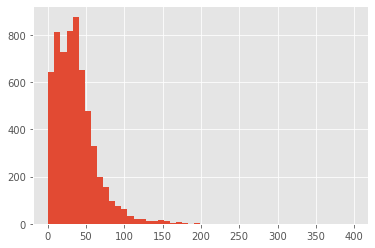

In [13]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.hist([len(s) for s in train_sentences], bins=50)
plt.show()

In [14]:
print('Max sentence length:',len(max(train_sentences+val_sentences, key=len)))

Max sentence length: 398



To avoid truncating sequences during padding we split our sentences to MAX_SEQUENCE_LENGTH. For example, if MAX_SEQUENCE_LENGTH=70, a sentence with length 150 splits in 3 sentences: 150=70+70+10

In [15]:
def  split(sentences, max):
    new=[]
    for data in sentences:
        new.append(([data[x:x+max] for x in range(0, len(data), max)]))
    new = [val for sublist in new for val in sublist]
    return new

In [16]:
MAX_SEQUENCE_LENGTH = 70

train_sentences = split(train_sentences, MAX_SEQUENCE_LENGTH)
val_sentences = split(val_sentences, MAX_SEQUENCE_LENGTH)
test_sentences = split(test_sentences, MAX_SEQUENCE_LENGTH)

In [18]:
train_sentences[0]

[('برلين', 'X'),
 ('ترفض', 'VERB'),
 ('حصول', 'NOUN'),
 ('شركة', 'NOUN'),
 ('اميركية', 'ADJ'),
 ('على', 'ADP'),
 ('رخصة', 'NOUN'),
 ('تصنيع', 'NOUN'),
 ('دبابة', 'NOUN'),
 ('"', 'PUNCT'),
 ('ليوبارد', 'X'),
 ('"', 'PUNCT'),
 ('الالمانية', 'ADJ')]

In [19]:
train_sentences = train_sentences + val_sentences + test_sentences

In [20]:
train_text = text_sequence(train_sentences)
train_tags = tag_sequence(train_sentences)

In [21]:
len(train_text)

8472

In [22]:
train_text[0], train_tags[0]

(['برلين',
  'ترفض',
  'حصول',
  'شركة',
  'اميركية',
  'على',
  'رخصة',
  'تصنيع',
  'دبابة',
  '"',
  'ليوبارد',
  '"',
  'الالمانية'],
 ['X',
  'VERB',
  'NOUN',
  'NOUN',
  'ADJ',
  'ADP',
  'NOUN',
  'NOUN',
  'NOUN',
  'PUNCT',
  'X',
  'PUNCT',
  'ADJ'])

In [23]:
embedding_dim = 300
MAX_SEQUENCE_LENGTH = 70
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [119]:
word_tokenizer = Tokenizer(oov_token = oov_tok)                    
word_tokenizer.fit_on_texts(train_text)  
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1                  
X_encoded_train = word_tokenizer.texts_to_sequences(train_text)  

In [120]:
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(train_tags)
Y_encoded_train = tag_tokenizer.texts_to_sequences(train_tags)

In [121]:
print("** Raw data point **", "\n", "-"*100, "\n")
print('X: ', train_text[0], '\n')
print('Y: ', train_tags[0], '\n')
print()
print("** Encoded data point **", "\n", "-"*100, "\n")
print('X: ', X_encoded_train[0], '\n')
print('Y: ', Y_encoded_train[0], '\n')

** Raw data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  ['برلين', 'ترفض', 'حصول', 'شركة', 'اميركية', 'على', 'رخصة', 'تصنيع', 'دبابة', '"', 'ليوبارد', '"', 'الالمانية'] 

Y:  ['X', 'VERB', 'NOUN', 'NOUN', 'ADJ', 'ADP', 'NOUN', 'NOUN', 'NOUN', 'PUNCT', 'X', 'PUNCT', 'ADJ'] 


** Encoded data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  [3936, 2492, 971, 89, 2082, 12, 3937, 1966, 3582, 10, 4888, 10, 1967] 

Y:  [7, 5, 1, 1, 3, 2, 1, 1, 1, 4, 7, 4, 3] 



In [122]:
X_padded_train = pad_sequences(X_encoded_train, maxlen=MAX_SEQUENCE_LENGTH, padding=padding_type, truncating=trunc_type)
Y_padded_train = pad_sequences(Y_encoded_train, maxlen=MAX_SEQUENCE_LENGTH, padding=padding_type, truncating=trunc_type)

X_train = X_padded_train
Y_train = Y_padded_train

In [123]:
X_train.shape

(8472, 70)

In [124]:
Y_train = to_categorical(Y_train)

In [125]:
Y_train.shape

(8472, 70, 18)

In [126]:
arvec_embedding = gensim.models.Word2Vec.load('full_grams_cbow_300_twitter.mdl')

In [127]:
embeddings_index = {}
for word,vector in zip(arvec_embedding.wv.vocab,arvec_embedding.wv.vectors):
    coefs = np.asarray(vector, dtype='float32')
    embeddings_index[word] = coefs

In [128]:
embeddings_matrix = np.zeros((VOCABULARY_SIZE, embedding_dim))
for word, i in word_tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

In [129]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.15, random_state=41)

In [130]:
X_train, X_valid , Y_train, Y_valid = train_test_split(X_train, Y_train, test_size = 0.15, random_state = 41)

In [131]:
# print number of samples in each set
print("TRAINING DATA")
print('Shape of input sequences: {}'.format(X_train.shape))
print('Shape of output sequences: {}'.format(Y_train.shape))
print("-"*50)
print("VALIDATION DATA")
print('Shape of input sequences: {}'.format(X_valid.shape))
print('Shape of output sequences: {}'.format(Y_valid.shape))
print("-"*50)
print("TESTING DATA")
print('Shape of input sequences: {}'.format(X_test.shape))
print('Shape of output sequences: {}'.format(Y_test.shape))

TRAINING DATA
Shape of input sequences: (6120, 70)
Shape of output sequences: (6120, 70, 18)
--------------------------------------------------
VALIDATION DATA
Shape of input sequences: (1081, 70)
Shape of output sequences: (1081, 70, 18)
--------------------------------------------------
TESTING DATA
Shape of input sequences: (1271, 70)
Shape of output sequences: (1271, 70, 18)


In [132]:
NUM_CLASSES = Y_train.shape[2]
NUM_CLASSES

18

In [346]:
model = Sequential()
model.add(InputLayer((MAX_SEQUENCE_LENGTH)))
model.add(Embedding(input_dim = VOCABULARY_SIZE,
                             output_dim    = embedding_dim,
                             input_length  = MAX_SEQUENCE_LENGTH,
                             #weights       = [embeddings_matrix],
                             trainable     = True
))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Bidirectional(LSTM(256, return_sequences=True)))

model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [347]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 70, 300)           7471800   
_________________________________________________________________
bidirectional_7 (Bidirection (None, 70, 512)           1140736   
_________________________________________________________________
bidirectional_8 (Bidirection (None, 70, 512)           1574912   
_________________________________________________________________
bidirectional_9 (Bidirection (None, 70, 512)           1574912   
_________________________________________________________________
time_distributed_6 (TimeDist (None, 70, 18)            9234      
Total params: 11,771,594
Trainable params: 11,771,594
Non-trainable params: 0
_________________________________________________________________


In [348]:
checkpoint = ModelCheckpoint('model_checkpoint.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [349]:
result = model.fit(X_train, Y_train, validation_data= (X_valid, Y_valid), epochs = 40, batch_size= 128, shuffle = True,callbacks=[checkpoint])

Epoch 1/40
48/48 [==============================] - 19s 215ms/step - loss: 1.5335 - accuracy: 0.5703 - val_loss: 0.9734 - val_accuracy: 0.6940

Epoch 00001: val_accuracy improved from -inf to 0.69400, saving model to model_checkpoint.h5
Epoch 2/40
48/48 [==============================] - 8s 166ms/step - loss: 0.9752 - accuracy: 0.6879 - val_loss: 0.8225 - val_accuracy: 0.7153

Epoch 00002: val_accuracy improved from 0.69400 to 0.71534, saving model to model_checkpoint.h5
Epoch 3/40
48/48 [==============================] - 8s 166ms/step - loss: 0.6657 - accuracy: 0.7788 - val_loss: 0.2953 - val_accuracy: 0.9096

Epoch 00003: val_accuracy improved from 0.71534 to 0.90962, saving model to model_checkpoint.h5
Epoch 4/40
48/48 [==============================] - 8s 166ms/step - loss: 0.2225 - accuracy: 0.9364 - val_loss: 0.1453 - val_accuracy: 0.9619

Epoch 00004: val_accuracy improved from 0.90962 to 0.96189, saving model to model_checkpoint.h5
Epoch 5/40
48/48 [============================

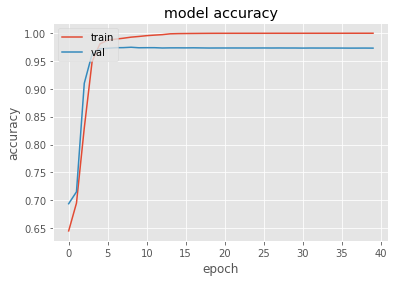

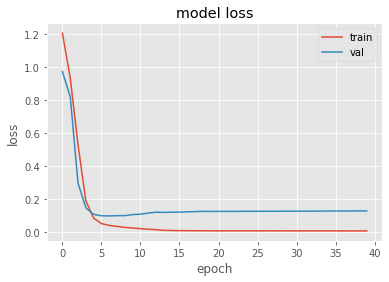

In [350]:
#Plot Accuracy
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='upper left')
plt.show()

#Plot Loss
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='upper right')
plt.show()

In [138]:
model.load_weights('model_checkpoint.h5')

In [139]:
loss, accuracy = model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

40/40 [==============================] - 1s 15ms/step - loss: 0.1276 - accuracy: 0.9721
Loss: 0.12756986916065216,
Accuracy: 0.9721142053604126


In [189]:
def classify(sentence):
  sentence = sentence.split()
  seq = [word_tokenizer.texts_to_sequences(sentence)]
  pad_seq = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH, padding=padding_type, truncating=trunc_type)
  pad_seq = np.squeeze(pad_seq,axis=-1)
  pred = np.squeeze(model.predict(pad_seq).argmax(-1))
  output = [tag_tokenizer.index_word[tag] for tag in pred if tag != 0]
  return output

In [190]:
sentence = "انا احب ان امارس الرياضة"
output = classify(sentence)
word_tag = [(sentence.split()[i],output[i]) for i in range(len(sentence.split()))]
print(word_tag)

[('انا', 'x'), ('احب', 'verb'), ('ان', 'sconj'), ('امارس', 'noun'), ('الرياضة', 'noun')]


In [194]:
Y_test_plot = Y_test.argmax(-1)
pred = np.squeeze(model.predict(X_test).argmax(-1))
print(Y_test_plot.shape)
print(pred.shape)

(1271, 70)
(1271, 70)


In [219]:
tag_names = tag_tokenizer.index_word
tag_names[18] = 'unknown'

In [244]:
name='Bert fine-tuned model'
print('\n------------ Result of {} ----------\n'.format(name))
print(classification_report(Y_test_plot.flatten(), pred.flatten(),digits=4,target_names=tag_names.values()))


------------ Result of Bert fine-tuned model ----------

              precision    recall  f1-score   support

        noun     0.9987    0.9999    0.9993     47438
         adp     0.9376    0.9511    0.9443     13937
         adj     0.9876    0.9946    0.9911      6265
       punct     0.8908    0.9061    0.8984      4269
        verb     0.9988    0.9997    0.9992      3219
       cconj     0.9226    0.8788    0.9002      3120
           x     0.9944    0.9867    0.9905      2865
        pron     0.7628    0.7127    0.7369      2513
         num     0.9955    0.9955    0.9955      1550
         det     0.9588    0.9380    0.9483      1242
       sconj     0.9476    0.9679    0.9576       840
        part     0.9872    0.9897    0.9885       780
         aux     0.9083    0.9475    0.9275       324
         adv     0.9113    0.8725    0.8915       306
         sym     0.9634    0.8587    0.9080       184
       propn     1.0000    0.9595    0.9793        74
        intj     0.8485

In [335]:
def plot_cm(f1,cm,target_names,title='Confusion matrix',cmap=None,normalize=True,i=1):



    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    plt.figure(figsize=(17, 17))
    if cmap is None:
        cmap = plt.get_cmap('Blues')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),fontsize=12,
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),fontsize=15,
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}; f1-score={:0.4f}'.format(accuracy, misclass, f1))

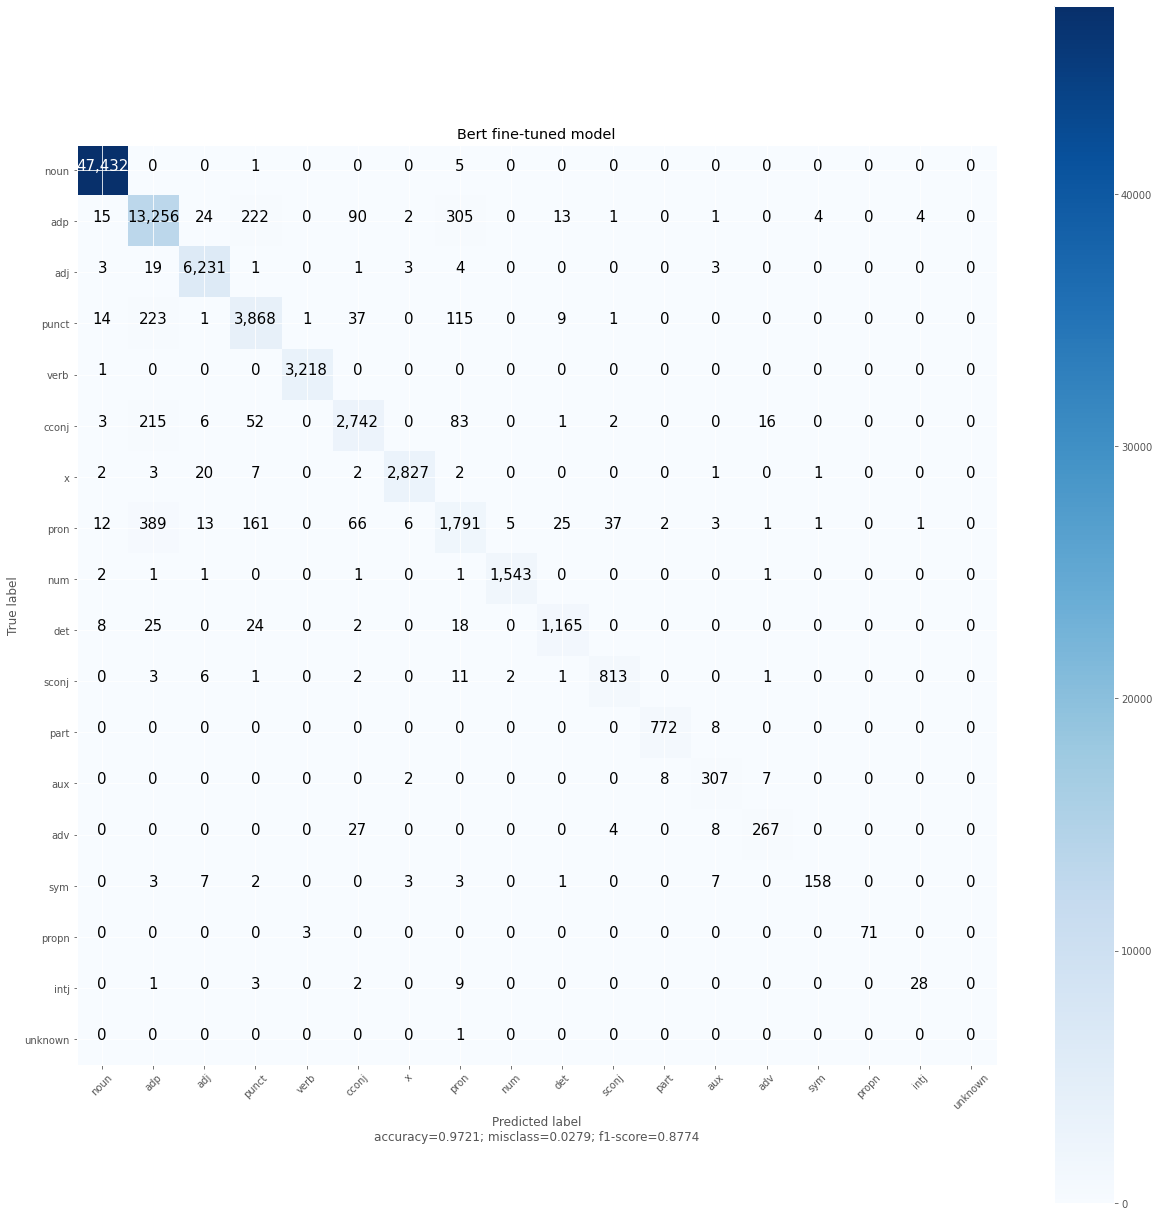

In [337]:
cnf_matrix = confusion_matrix(Y_test_plot.flatten(), pred.flatten())
plot_cm(f1_score(Y_test_plot.flatten(), pred.flatten(), average='macro'), cnf_matrix, target_names=tag_names.values(), title=name, normalize=False)